# 1. Load whisper

In [1]:
import whisper
model = whisper.load_model("medium.en")

C:\Users\lipku\miniconda3\envs\venv_ee3801\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=

In [2]:
!pip install pandas
!pip install -U scikit-learn
!pip install nltk
!pip install matplotlib
!pip install sentence_transformers

# 2. Consume audio stream and transcribe

# 2.1 Initialise Consumer

In [3]:
import pyaudio

FORMAT = pyaudio.paInt16
CHUNK = 1024
RECORD_SECONDS = 5
# changed device id to 1
DEVICE_ID = 1

audio = pyaudio.PyAudio()
RATE = int(audio.get_device_info_by_index(DEVICE_ID)['defaultSampleRate'])
CHANNELS = int(audio.get_device_info_by_index(DEVICE_ID)['maxInputChannels'])

stream = audio.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    frames_per_buffer=CHUNK,
    input_device_index=DEVICE_ID
)

In [9]:
# kafka-python Consumer
from kafka import KafkaConsumer
import json
import numpy as np
from datetime import datetime
import sys
from scipy.signal import resample

# To consume latest messages and auto-commit offsets
consumer = KafkaConsumer('dataengineering',
                        #  group_id='python-consumer',
                         bootstrap_servers=['localhost:29092','localhost:39092','localhost:49092'])
                        #  consumer_timeout_ms=1000)
                         #value_deserializer=lambda m: json.loads(m.decode('utf-8')))

start_time = datetime.now()

try: 
    for message in consumer:
        print(datetime.now()-start_time)
        begin_time = datetime.now()
        # message value and key are raw bytes -- decode if necessary!
        # e.g., for unicode: `message.value.decode('utf-8')`
        print("%s %s:%d:%d: key=%s" % (datetime.now().strftime("%d/%m/%Y, %H:%M:%S"), message.topic, message.partition,
                                            message.offset, message.key.decode('utf-8')))

        if message.key.decode('utf-8')=="text":
            print("message=%s" % message.value.decode('utf-8'))

        if message.key.decode('utf-8')=="audio":
            audio_data = np.frombuffer(message.value, dtype=np.int16).flatten().astype(np.float32) / 32768.0
            audio_data = whisper.pad_or_trim(audio_data)
            before_transcribe_time = datetime.now()
            sample_rate = int(len(audio_data)*16000/RATE)
            audio_data = resample(audio_data,num = sample_rate)
            text = whisper.transcribe(model, audio_data, fp16=False)["text"]
            print("transcribed.message=%s, transcribed.duration=%s" % (text, 
                                                                       str(datetime.now()-before_transcribe_time)))

        # if (datetime.now()-start_time).seconds > 60: # listen for 1 minute (60 seconds)
        if (datetime.now()-start_time).seconds > 270: # listen for 4 minute 30 sec (270 seconds)
            consumer.close()
            print("* Ended listening for 1 min *")
            break
except KeyboardInterrupt as kie:
    consumer.close()
    print("* Program terminated by user *")

0:03:05.917380
04/11/2024, 12:48:27 dataengineering:0:179: key=audio
transcribed.message= Producers are fairly straightforward., transcribed.duration=0:00:23.011318
0:03:28.952286
04/11/2024, 12:48:50 dataengineering:0:180: key=audio
transcribed.message= producers are very straightforward, transcribed.duration=0:00:21.764327
0:03:50.720213
04/11/2024, 12:49:12 dataengineering:0:181: key=audio
transcribed.message= Producers are famous straight forward., transcribed.duration=0:00:22.448064
0:04:13.219180
04/11/2024, 12:49:34 dataengineering:0:182: key=audio
transcribed.message= Producers are fairly straightforward., transcribed.duration=0:00:22.602657
* Ended listening for 1 min *


In [6]:
print(datetime.now())

2024-11-04 12:28:30.966994


# 3. Consume audio stream, transcribe and identify number of speakers

# 3.1 Detect speakers

In [10]:
!pip3 install pyannote.audio
!pip3 install torch torchvision torchaudio

  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


  You can safely remove it manually.
  You can safely remove it manually.


In [ ]:
### diarization - https://github.com/pyannote/pyannote-audio/tree/develop?tab=readme-ov-file
from pyannote.audio import Pipeline
import torchaudio
import torch
import pyaudio
from scipy.signal import resample

DEVICE_ID = 1
audio = pyaudio.PyAudio()
RATE = int(audio.get_device_info_by_index(DEVICE_ID)['defaultSampleRate'])
CHANNELS = int(audio.get_device_info_by_index(DEVICE_ID)['maxInputChannels'])
audio.terminate()

speaker_list = []
waveform = []

def detect_speakers(audio_data_):
    # add my access token
    pipeline = Pipeline.from_pretrained(
        "pyannote/speaker-diarization-3.1",
        use_auth_token="")

    # send pipeline to GPU (when available)
    pipeline.to(torch.device("cpu"))

    # apply pretrained pipeline
    # waveform, sample_rate = torchaudio.load("output.wav")
    waveform.append(audio_data_)
    # audio_data_ = torch.from_numpy(audio_data_).float().unsqueeze(dim=0).to(device=torch.device('cpu'))
    # print("audio_data_.shape:",audio_data_.shape[0])
    this_waveform = torch.from_numpy(np.array(waveform)).float().to(device=torch.device('cpu'))

    
    diarization = pipeline({"waveform": this_waveform, "sample_rate": RATE})

    # print the result
    for turn, _, speaker in diarization.itertracks(yield_label=True):
        print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")
        speaker_list.append(speaker)

    return diarization

In [17]:
# kafka-python Consumer
from kafka import KafkaConsumer
import json
import numpy as np
from datetime import datetime
import sys
from scipy.signal import resample

# To consume latest messages and auto-commit offsets
consumer = KafkaConsumer('dataengineering',
                        #  group_id='python-consumer',
                         bootstrap_servers=['localhost:29092','localhost:39092','localhost:49092'])
                        #  consumer_timeout_ms=1000)
                         #value_deserializer=lambda m: json.loads(m.decode('utf-8')))

start_time = datetime.now()

try: 
    for message in consumer:
        print(datetime.now()-start_time)
        begin_time = datetime.now()
        # message value and key are raw bytes -- decode if necessary!
        # e.g., for unicode: `message.value.decode('utf-8')`
        print("%s %s:%d:%d: key=%s" % (datetime.now().strftime("%d/%m/%Y, %H:%M:%S"), message.topic, message.partition,
                                            message.offset, message.key.decode('utf-8')))

        if message.key.decode('utf-8')=="text":
            print("message=%s" % message.value.decode('utf-8'))

        if message.key.decode('utf-8')=="audio":
            audio_data = np.frombuffer(message.value, dtype=np.int16).flatten().astype(np.float32) / 32768.0
            audio_data = whisper.pad_or_trim(audio_data)
            before_transcribe_time = datetime.now()
            
            sample_rate = int(len(audio_data)*16000/RATE)
            audio_data = resample(audio_data,num = sample_rate)
            text = whisper.transcribe(model, audio_data, fp16=False)["text"]
            print("transcribed.message=%s, transcribed.duration=%s" % (text, 
                                                                       str(datetime.now()-before_transcribe_time)))
            # detect speakers
            dia = detect_speakers(audio_data)
            print("Number of speakers detected:",len(list(dict.fromkeys(speaker_list))))


        if (datetime.now()-start_time).seconds > 270: # listen for 4 minute 30 sec (270 seconds)
            consumer.close()
            print("* Ended listening for 1 min *")
            break
except KeyboardInterrupt as kie:
    consumer.close()
    print("* Program terminated by user *")


INFO:kafka.conn:<BrokerConnection node_id=bootstrap-2 host=localhost:39092 <connecting> [IPv6 ('::1', 39092, 0, 0)]>: connecting to localhost:39092 [('::1', 39092, 0, 0) IPv6]
INFO:kafka.conn:Probing node bootstrap-2 broker version
INFO:kafka.conn:<BrokerConnection node_id=bootstrap-2 host=localhost:39092 <connecting> [IPv6 ('::1', 39092, 0, 0)]>: Connection complete.
INFO:kafka.conn:Broker version identified as 2.6.0
INFO:kafka.conn:Set configuration api_version=(2, 6, 0) to skip auto check_version requests on startup
INFO:kafka.consumer.subscription_state:Updating subscribed topics to: ('dataengineering',)
INFO:kafka.consumer.subscription_state:Updated partition assignment: [TopicPartition(topic='dataengineering', partition=0)]
INFO:kafka.conn:<BrokerConnection node_id=6 host=host.docker.internal:49092 <connecting> [IPv4 ('127.0.0.1', 49092)]>: connecting to host.docker.internal:49092 [('127.0.0.1', 49092) IPv4]
INFO:kafka.conn:<BrokerConnection node_id=6 host=host.docker.internal:49

0:03:13.531457
04/11/2024, 13:14:02 dataengineering:0:218: key=audio
transcribed.message= Producers are fairly straightforward., transcribed.duration=0:00:10.958029


C:\Users\lipku\miniconda3\envs\venv_ee3801\Lib\site-packages\pyannote\audio\models\blocks\pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  std = sequences.std(dim=-1, correction=1)


start=0.3s stop=1.2s speaker_SPEAKER_00
Number of speakers detected: 1
0:03:42.951110
04/11/2024, 13:14:32 dataengineering:0:219: key=audio
transcribed.message= fairly straightforward. The producers are fairly straightforward., transcribed.duration=0:00:12.057986


C:\Users\lipku\miniconda3\envs\venv_ee3801\Lib\site-packages\pyannote\audio\models\blocks\pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  std = sequences.std(dim=-1, correction=1)


start=0.0s stop=1.6s speaker_SPEAKER_00
start=0.8s stop=0.9s speaker_SPEAKER_01
start=0.9s stop=1.0s speaker_SPEAKER_01
start=1.0s stop=1.1s speaker_SPEAKER_01
start=1.1s stop=1.1s speaker_SPEAKER_01
Number of speakers detected: 2
0:04:15.372270
04/11/2024, 13:15:04 dataengineering:0:220: key=audio
transcribed.message= Producers are fairly straightforward., transcribed.duration=0:00:09.662944


C:\Users\lipku\miniconda3\envs\venv_ee3801\Lib\site-packages\pyannote\audio\models\blocks\pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  std = sequences.std(dim=-1, correction=1)
INFO:kafka.conn:<BrokerConnection node_id=6 host=host.docker.internal:49092 <connected> [IPv4 ('127.0.0.1', 49092)]>: Closing connection. 


start=0.0s stop=1.1s speaker_SPEAKER_00
start=1.1s stop=1.1s speaker_SPEAKER_00
Number of speakers detected: 2
* Ended listening for 1 min *


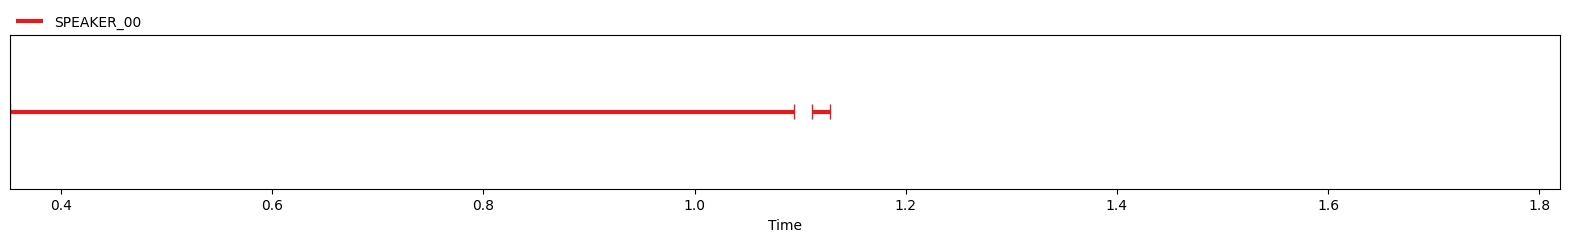

In [19]:
dia

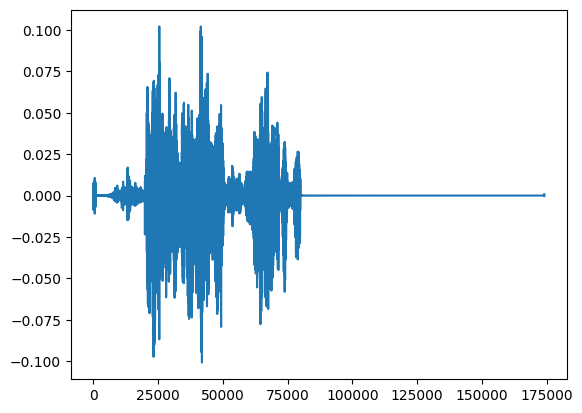

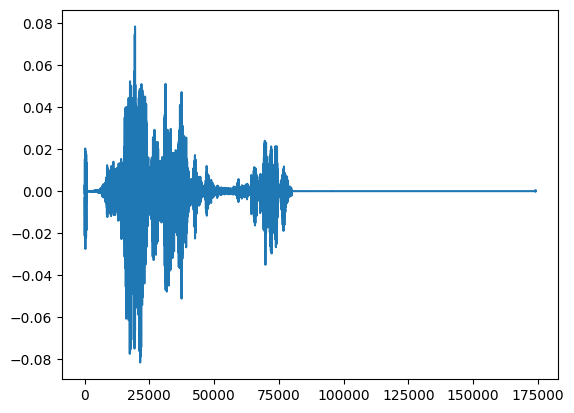

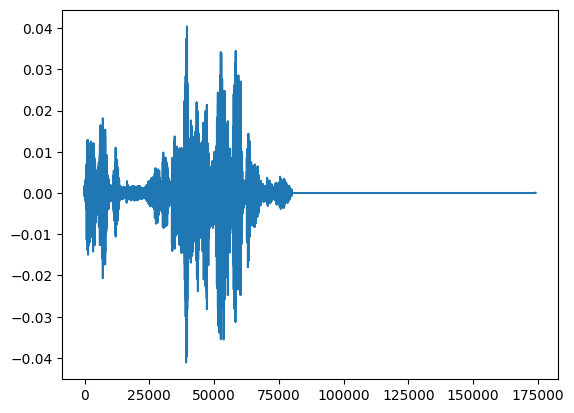

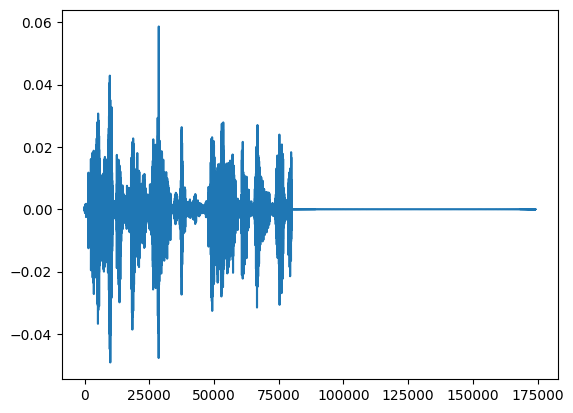

In [20]:
import matplotlib.pyplot as plt

for wave in waveform:
    plt.plot(np.array(wave))
    plt.show()

~ The End ~